# Delay-cost regression on the arrival management tactical cost

-  This notebook computes a fit-function of the cost of delay on the arrival management presented in the following report:

 **A. J. Cook, G. Tanner, European airline delay cost reference values,
Technical Report, Transport Studies Group, University of Westminster,
London, UK, 2011**. Available [here](https://www.eurocontrol.int/sites/default/files/publication/files/european-airline-delay-cost-reference-values-final-report-4-1.pdf).


- The cost concerned is the tactical cost in arrival management : **Tables 25 and 29**. 

- All costs are in euros, as in [Cook and Tanner](https://www.eurocontrol.int/sites/default/files/publication/files/european-airline-delay-cost-reference-values-final-report-4-1.pdf) report

- This fit-function will enable us to extrapolate the cost for other aircraft non-present in [Cook and Tanner](https://www.eurocontrol.int/sites/default/files/publication/files/european-airline-delay-cost-reference-values-final-report-4-1.pdf) database.

- These costs are then integrated in our new instances for the Aircraft Landing Problem, available at
http://data.recherche.enac.fr/ikli-alp/.



## Dependencies

In order to execute the cells of this notebook, you will need:

- [Jupyter Notebook Software](https://jupyter.org/).
- **Python 3.X** with [numpy](https://numpy.org/install/), [matplotlib](https://matplotlib.org/3.3.1/users/installing.html), and [pandas](https://pandas.pydata.org/pandas-docs/version/0.23.3/install.html).
- The two images **primal-cost.png** and **full-cost.png**.


## Technical notes

* We choose a **linear regression** fit-function, in **least squares sense**.

* This regression is of the form $Ax = b$, where $b$ is the vector of the costs, and $A$ is the matrix of the **number of seats** and the **fuel burn** (kg/h). These last two parameters (number of seats and fuel burn) are chosen because they are usually the most dominant in the total delay cost.

    * The matrix $A$ and the cost $b$ are constructed as follows:
 
       * $A \in \mathcal{M}_{(14,2)}  $ :  \begin{bmatrix}
                                    seats_{1} & fuel_{1} \\
                                      .       &     .    \\
                                      .       &     .    \\
                                      .       &     .     \\
                                      seats_{14} & fuel_{14} \\
                                    \end{bmatrix} 

       * $b \in \mathcal{M}_{(14,1)}  $ :\begin{bmatrix}
                                    cost_{1}\\
                                    .\\
                                    .\\
                                    .\\
                                    cost_{14} 
                                    \end{bmatrix} 
                                    
      * Each row (in $A$ or $b$) contains parameters's values for the $14$ aircraft of [Cook and Tanner](https://www.eurocontrol.int/sites/default/files/publication/files/european-airline-delay-cost-reference-values-final-report-4-1.pdf) data base.
                                    
       
        

* The unknown is the vector of regression coefficients $x = (x_{1},x_{2})$ which has two componenents: 

    * $x_{1}$ : the regression coefficient for the **number of seats**.

    * $x_{2}$ : the regression coefficient for the **fuel burn** (kg/h). 
 

* In other words, we would like to find coefficients $x_{1}$ and $x_{2}$ s.t. 
$$ \mathbf{b = x_{1}*seats + x_{2}*fuel} $$
  
    * i.e.,  Find, in least squares sense, $x = (x_{1},x_{2})$ s.t $$Ax = b $$
    
    * i.e., $$ x = arg\min( ||Ax - b|| ) $$
 
    * The solution is given by the **normal equation**:  $$A^{t}A x = A^{t}b$$
    
    * **Thus** $$\mathbf{x = (A^{t}A)^{-1} A^{t}b} $$

 
 
* The number of seats for each aircraft is taken from [wikipédia](https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft), and the fuel burn is from the [airliners.net](https://www.airliners.net/forum/viewtopic.php?t=1355819) forum. 

* All scenarios are **base cost scenarios**.

* The **Coefficient of determination $r^{2}$** is chosen to examine the performance of the fit-function.




## <font color='blue'>1 . Primary tactical cost </font> 

First, we compute the regression coefficients $x = (x_{1}, x_{2})$ for the **primary tactical cost**

 i.e., Table 25 **ARRIVAL MGT / BASE / primary tactical cost**, from [Cook and Tanner](https://www.eurocontrol.int/sites/default/files/publication/files/european-airline-delay-cost-reference-values-final-report-4-1.pdf) report.

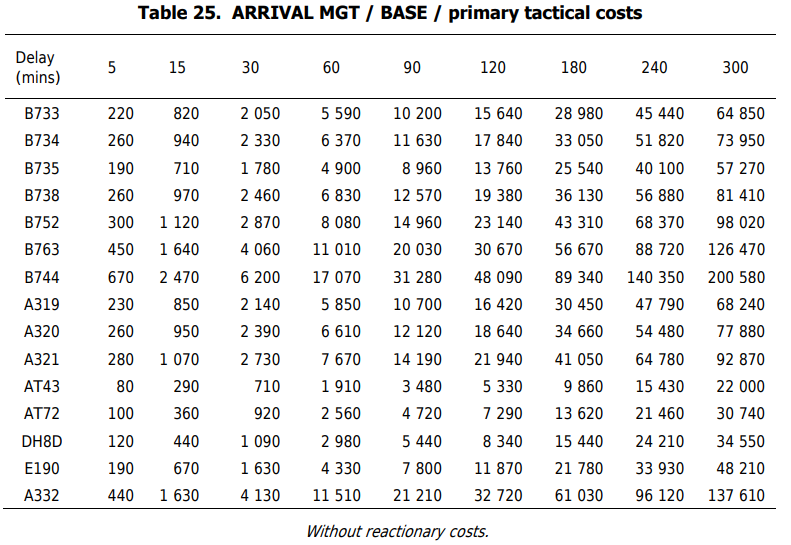

In [29]:
import numpy  as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D 

Image(filename = 'primal-cost.png')


In [30]:
# cook_ac is a dictionary. 
# Each key represents an aircraft type from cook and Tanner report
# Each value is a 2-D list where:
# The first component is the  Nb of seats            
# The second component is the fuel burn (kg/h)

cook_ac = {'B733': [127,2731] , 'B734': [145,2588] , 'B735': [113,2530] , 'B738': [161,2187],
           'B752': [200,2789] , 'B763': [279,3908] , 'B744': [416,7421] , 'A319': [124,1854],
           'A320': [150,2074] , 'A321': [180,2625] , 'AT43': [43,392]   , 'AT72': [60,504]  ,
           'E190': [106,856]  , 'A332': [241,5590] }

In [31]:
# cook_delay is a dictionary. 
# Its keys represent aircraft types
# Its values represent the delay-cost values for the following delay break-points: 
# 5, 15, 30, 60, 90, 120, 180, 240, and 300 minutes

cook_delay = {'B733' : [220 , 820  , 2050 , 5590  , 10200 , 15640 , 28980 , 45440  , 64850 ],
              'B734' : [260 , 940  , 2330 , 6370  , 11630 , 17840 , 33050 , 51820  , 73950 ],
              'B735' : [190 , 710  , 1780 , 4900  , 8960  , 13760 , 25540 , 40100  , 57270 ],
              'B738' : [260 , 970  , 2460 , 6830  , 12570 , 19380 , 36130 , 56880  , 81410 ],
              'B752' : [300 , 1120 , 2870 , 8080  , 14960  ,23140 , 43310 , 68370  , 98020 ],
              'B763' : [450 , 1640 , 4060 , 11010 , 20030 , 30670 , 56670 , 88720  , 126470],
              'B744' : [670 , 2470 , 6200 , 17070 , 31280 , 48090 , 89340 , 140350 , 200580],
              'A319' : [230 , 850  , 2140 , 5850  , 10700 , 16420 , 30450 , 47790  , 68240 ],
              'A320' : [260 , 950  , 2390 , 6610  , 12120 , 18640 , 34660 , 54480  , 77880 ],
              'A321' : [280 , 1070 , 2730 , 7670  , 14190 , 21940 , 41050 , 64780  , 92870 ],
              'AT43' : [80  , 290  , 710  , 1910  , 3480  , 5330  , 9860  , 15430  , 22000 ],
              'AT72' : [100 , 360  , 920  , 2560  , 4720  , 7290  , 13620 , 21460  , 30740 ],
              'E190' : [190 , 670  , 1630 , 4330  , 7800  , 11870 , 21780 , 33930  , 48210 ],
              'A332' : [440 , 1630 , 4130 , 11510 , 21210 , 32720 , 61030 , 96120  , 137610]}

In [32]:
# Lets visualize the Nb of seats and fuel burn for each aircraft type from 
# the dictionary cook_delay
ac_seats_fuel      = pd.DataFrame(cook_ac)
l                  = ['Seats', 'Fuel burn (kg/h)']
ac_seats_fuel[' '] = l
ac_seats_fuel      = ac_seats_fuel.set_index(' ')
ac_seats_fuel

,B733,B734,B735,B738,B752,B763,B744,A319,A320,A321,AT43,AT72,E190,A332
,,,,,,,,,,,,,,
Seats,127,145,113,161,200,279,416,124,150,180,43,60,106,241
Fuel burn (kg/h),2731,2588,2530,2187,2789,3908,7421,1854,2074,2625,392,504,856,5590


In [33]:
# Let's construct the Matrix A, composed of the number of seats and the fuel burn,
# for each of the above-mentionned aircraft types

a = [cook_ac[idx] for idx in cook_ac.keys() ]
A = np.array((a))
print("\n* A =", A)
print("\n* Shape of the the matrix A =", A.shape)



* A = [[ 127 2731]
 [ 145 2588]
 [ 113 2530]
 [ 161 2187]
 [ 200 2789]
 [ 279 3908]
 [ 416 7421]
 [ 124 1854]
 [ 150 2074]
 [ 180 2625]
 [  43  392]
 [  60  504]
 [ 106  856]
 [ 241 5590]]

* Shape of the the matrix A = (14, 2)


In [34]:
# Let's construct the vector Right hand side b, composed of the delay costs,
# for each of the above-mentionned aircraft types
# At first, we show this vector for the break point 5 minutes only :

b = [cook_delay[idx][0] for idx in cook_delay.keys() ]
b = np.array(b)
print("\n* b =", b)
print("\n* Shape of the right hand side vector  =", b.shape)


* b = [220 260 190 260 300 450 670 230 260 280  80 100 190 440]

* Shape of the right hand side vector  = (14,)


###  The matrices $A^{T}$, $A^{T}A$ , and $(A^{T}A)^{-1}$ 

In [35]:
A_transpose = A.transpose() 
print("\n* A_transpose =", A_transpose)

ATA = np.matmul(A_transpose, A)
print("\n* ATA =", ATA)

inv_ATA     = np.linalg.inv(ATA)
print("\n* inv_ATA =", inv_ATA)


* A_transpose = [[ 127  145  113  161  200  279  416  124  150  180   43   60  106  241]
 [2731 2588 2530 2187 2789 3908 7421 1854 2074 2625  392  504  856 5590]]

* ATA = [[   511783   8593880]
 [  8593880 150480133]]

* inv_ATA = [[ 4.76444122e-05 -2.72095959e-06]
 [-2.72095959e-06  1.62038667e-07]]


### Vector of coefficients $x$ for $5$ minutes break point

In [36]:
x = np.matmul(inv_ATA, np.matmul(A_transpose, b) )

print("\n* x =", x)


* x = [1.44808196 0.01229669]


### Vector of coefficients x for all the delay break points

In [37]:
# x : vector of regression coefficients for all delay break points (5, 15, ...)

def x_coeff(delays_bp, A, cook_delay):
    
    x = {}

    for i in range(len(delays_bp)):
        b = [cook_delay[idx][i] for idx in cook_delay.keys() ]
        b = np.array(b)
        x[delays_bp[i]] = np.matmul(inv_ATA, np.matmul(A_transpose, b) )
    
    return x 

delays_bp = [5 , 15 , 30 , 60 , 90 , 120 , 180 , 240 , 300]
x         = x_coeff(delays_bp, A, cook_delay)

x

{5: array([1.44808196, 0.01229669]),
 15: array([5.22389933, 0.05246025]),
 30: array([12.93711975,  0.14306018]),
 60: array([34.97458488,  0.43548921]),
 90: array([63.59229972,  0.8303167 ]),
 120: array([97.33330135,  1.30518358]),
 180: array([179.83717707,   2.4899475 ]),
 240: array([281.49383133,   3.97881196]),
 300: array([401.22714283,   5.75426107])}

### Visualization of the regression plan (5 min break point)

Populating the interactive namespace from numpy and matplotlib


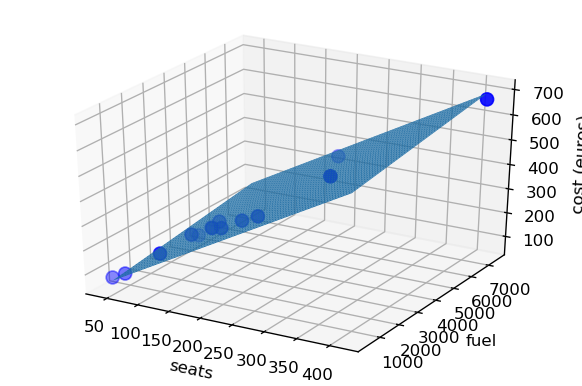

In [38]:
# x, y and z axes :

x_cook = [cook_ac[ac][0]    for ac in cook_ac.keys()]    # x-label : seats
y_cook = [cook_ac[ac][1]    for ac in cook_ac.keys()]    # y-label : fuel
z_cook = [cook_delay[ac][0] for ac in cook_delay.keys()] # z-label : cost for the 5 min bp

#-----------------------------------------------------------
# Regression plan drawing 
%pylab inline
fig    = plt.figure(dpi = 120)
ax     = plt.gca(projection="3d")

xx_cook          = np.arange(min(x_cook), max(x_cook))
yy_cook          = np.arange(min(y_cook), max(y_cook))
xx_cook, yy_cook = meshgrid(xx_cook, yy_cook)
ax.plot_surface(xx_cook, yy_cook, x[5][0]*xx_cook +x[5][1]*yy_cook) # regression plane plot
#-----------------------------------------------------------

ax.scatter(x_cook, y_cook, z_cook , c='b',s=60)
ax.set_xlabel('seats')
ax.set_ylabel('fuel')
ax.set_zlabel('cost (euros)')

plt.savefig('regression_plan.png')

### Approximation for new aircraft

In [39]:
new_ac = {'A343' : [262,6500] , 'E145': [50,1120] , 'A333': [262,5700] , 'A318': [132,2200], 
          'B77W' : [550,7500] , 'CRJX': [50,1740] , 'RJ85': [111,2060] , 'B737': [162,2420],
          'B772' : [305,6630] , 'AT45': [48,620]  , 'CRJ7': [70,1450]  , 'E170': [78,1530]}

def regression(x, new_ac):
    
    new_ac_delays = {}
    for ac in new_ac.keys():
        new_ac_delays[ac] = [int( (x[bp][0])* new_ac[ac][0]  +  (x[bp][1]) * new_ac[ac][1] )  
                            for bp in x.keys() ]
        
    return new_ac_delays

new_ac_delays = regression(x, new_ac)

new_ac_delays

{'A343': [459, 1709, 4319, 11994, 22058, 33985, 63301, 99613, 142524],
 'E145': [86, 319, 807, 2236, 4109, 6328, 11780, 18530, 26506],
 'A333': [449, 1667, 4204, 11645, 21393, 32940, 61310, 96430, 137920],
 'A318': [218, 804, 2022, 5574, 10220, 15719, 29216, 45910, 65621],
 'B77W': [888, 3266, 8188, 22502, 41203, 63322, 117585, 184662, 263831],
 'CRJX': [93, 352, 895, 2506, 4624, 7137, 13324, 20997, 30073],
 'RJ85': [186, 687, 1730, 4779, 8769, 13492, 25091, 39442, 56389],
 'B737': [264, 973, 2442, 6719, 12311, 18926, 35159, 55230, 78924],
 'B772': [523, 1941, 4894, 13554, 24900, 38340, 71358, 112235, 160525],
 'AT45': [77, 283, 709, 1948, 3567, 5481, 10175, 15978, 22826],
 'CRJ7': [119, 441, 1113, 3079, 5655, 8705, 16199, 25473, 36429],
 'E170': [131, 487, 1227, 3394, 6230, 9588, 17836, 28044, 40099]}

### Visualization of regression results

* Let's visualize the **regression cost** vs **original cost** for some aircraft from [cook and Tanner](https://www.eurocontrol.int/sites/default/files/publication/files/european-airline-delay-cost-reference-values-final-report-4-1.pdf) database

Populating the interactive namespace from numpy and matplotlib


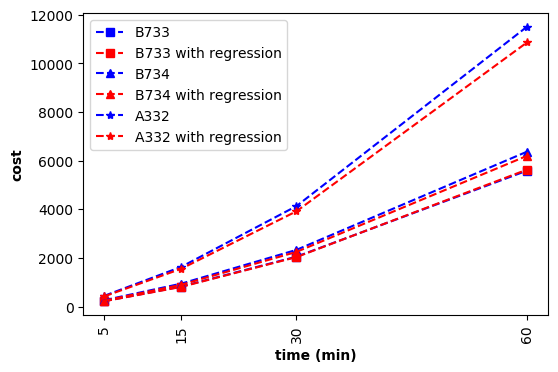

In [40]:
%pylab inline

B733   = cook_delay['B733']
B734   = cook_delay['B734']
A332   = cook_delay['A332']

cook_reg_cost = regression(x, cook_ac)

B733_r = cook_reg_cost['B733']
B734_r = cook_reg_cost['B734']
A332_r = cook_reg_cost['A332']


fig = plt.figure(dpi = 100)
ocs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.xticks(delays_bp)
plt.plot(delays_bp[:4], B733[:4]  , 'bs--', label ='B733')
plt.plot(delays_bp[:4], B733_r[:4], 'rs--', label ='B733 with regression')

plt.plot(delays_bp[:4], B734[:4]  , 'b^--', label ='B734')
plt.plot(delays_bp[:4], B734_r[:4], 'r^--', label ='B734 with regression')

plt.plot(delays_bp[:4], A332[:4]  , 'b*--', label ='A332')
plt.plot(delays_bp[:4], A332_r[:4], 'r*--', label ='A332 with regression')


plt.xlabel("time (min)", fontweight='bold')
plt.ylabel("cost",fontweight='bold')
plt.legend(loc='upper left')
plt.show()


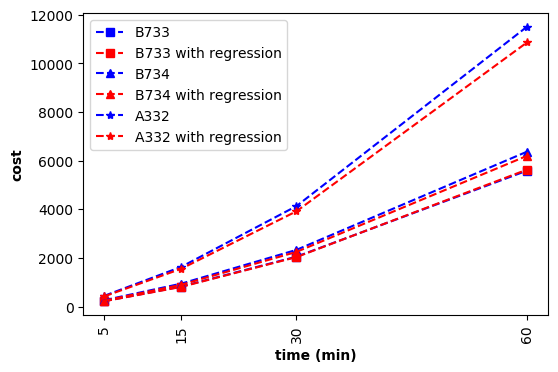

In [41]:
fig = plt.figure(dpi = 100)
ocs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.xticks(delays_bp)
plt.plot(delays_bp[:4], B733[:4]  , 'bs--', label ='B733')
plt.plot(delays_bp[:4], B733_r[:4], 'rs--', label ='B733 with regression')

plt.plot(delays_bp[:4], B734[:4]  , 'b^--', label ='B734')
plt.plot(delays_bp[:4], B734_r[:4], 'r^--', label ='B734 with regression')

plt.plot(delays_bp[:4], A332[:4]  , 'b*--', label ='A332')
plt.plot(delays_bp[:4], A332_r[:4], 'r*--', label ='A332 with regression')


plt.xlabel("time (min)", fontweight='bold')
plt.ylabel("cost",fontweight='bold')
plt.legend(loc='upper left')
plt.show()

### Coefficient of determination $r^{2}$

* Let's compute the Coefficient of determination $r^{2}$ to measure the quality of our regression function

* This coefficient is computed as follows 
$$ r^{2} = 1 - \frac{\sum_{i=1}^{n}(c_{i} - \hat{c_{i}})^{2}}{\sum_{i=1}^{n}(c_{i} - \bar{c})^{2}} $$

Where: $n$ is the total number of samples, $c_{i}$ is the true cost, $\hat{c_{i}}$ is the estimated cost, and $\bar{c}$ is the mean value of the sample costs.

In [42]:
c     = cook_delay                # c    : the true cost
c_hat = regression(x, cook_ac)    # c_hat: the estimated cost
 
c_df  = pd.DataFrame.from_dict(c, orient='index', columns=delays_bp)
c_bar = c_df.mean()               # c_bar: the mean cost on the samples

In [43]:
# R: is a vector of Coefficients of determination, for each delay break point 5, 15, ...

from sklearn.metrics import r2_score

R = []
for i in range(len(delays_bp)):
    cc     = [c[ac][i]     for ac in c.keys()]
    cc_hat = [c_hat[ac][i] for ac in c_hat.keys()]
    R.append(r2_score(cc, cc_hat))
    

#### * Visualization of coefficient of determination ($r^{2}$) and regression coefficients ($x_{1}$ and $x_{2}$)

In [44]:
df = {'$x_{1}$': [round(x[i][0],3) for i in x.keys()],
      '$x_{2}$': [round(x[i][1],3) for i in x.keys()],
      '$r^{2}$': [round(i,3)       for i in R]
     }
primal_cost_table = pd.DataFrame.from_dict(df, orient='index', columns=delays_bp)
primal_cost_table

,5,15,30,60,90,120,180,240,300
$x_{1}$,1.448,5.224,12.937,34.975,63.592,97.333,179.837,281.494,401.227
$x_{2}$,0.012,0.052,0.143,0.435,0.830,1.305,2.490,3.979,5.754
$r^{2}$,0.986,0.989,0.990,0.989,0.988,0.988,0.987,0.986,0.986


## <font color='blue'>2 . Full tactical cost </font> 

Now, we compute the regression coefficients $x = (x_{1}, x_{2})$ for the **Full tactical cost**

 i.e., Table 29 **ARRIVAL MGT / BASE / full tactical cost** (with reactionary costs), from [Cook and Tanner](https://www.eurocontrol.int/sites/default/files/publication/files/european-airline-delay-cost-reference-values-final-report-4-1.pdf) report.

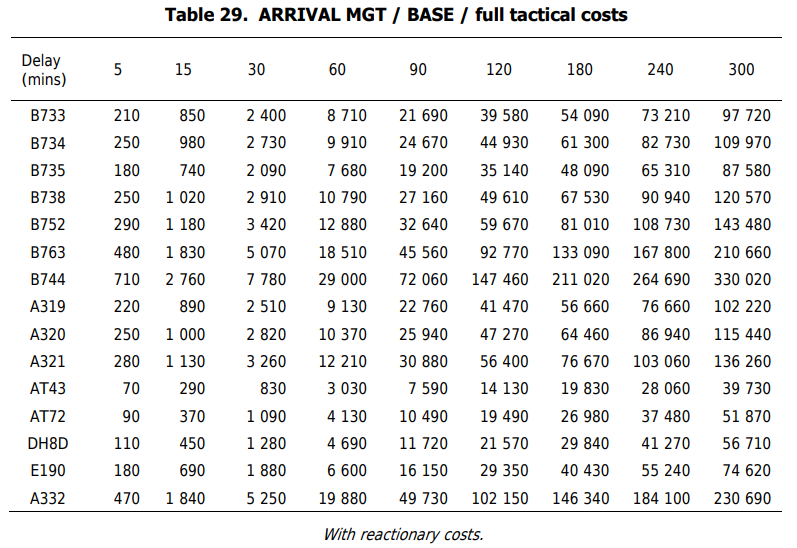

In [45]:
Image(filename = 'full-cost.png')

In [46]:
# cook_delay_reac is a dictionary similar to cook_delay, but with reactionary costs from the above table
# The matrix A is unchanged
# The vector of costs b is updated with the new reactionary costs

cook_delay_reac = {'B733' : [210 , 850  , 2400 , 8710  , 21690 , 39580  , 54090  , 73210  , 97720  ],
                   'B734' : [250 , 980  , 2730 , 9910  , 24670 , 44930  , 61300  , 82730  , 109970 ],
                   'B735' : [180 , 740  , 2090 , 7680  , 19200 , 35140  , 48090  , 65310  , 87580  ],
                   'B738' : [250 , 1020 , 2910 , 10790 , 27160 , 49610  , 67530  , 90940  , 120570 ],
                   'B752' : [290 , 1180 , 3420 , 12880 , 32640 , 59670  , 81010  , 108730 , 143480 ],
                   'B763' : [480 , 1830 , 5070 , 18510 , 45560 , 92770  , 133090 , 167800 , 210660 ],
                   'B744' : [710 , 2760 , 7780 , 29000 , 72060 , 147460 , 211020 , 264690 , 330020 ],
                   'A319' : [220 , 890  , 2510 , 9130  , 22760 , 41470  , 56660  , 76660  , 102220 ],
                   'A320' : [250 , 1000 , 2820 , 10370 , 25940 , 47270  , 64460  , 86940  , 115440 ],
                   'A321' : [280 , 1130 , 3260 , 12210 , 30880 , 56400  , 76670  , 103060 , 136260 ],
                   'AT43' : [70  , 290  , 830  , 3030  , 7590  , 14130  , 19830  , 28060  , 39730  ],
                   'AT72' : [90  , 370  , 1090 , 4130  , 10490 , 19490  , 26980  , 37480  , 51870  ],
                   'E190' : [180 , 690  , 1880 , 6600  , 16150 , 29350  , 40430  , 55240  , 74620  ],
                   'A332' : [470 , 1840 , 5250 , 19880 , 49730 , 102150 , 146340 , 184100 , 230690 ]}

b_reac = [cook_delay_reac[idx][0] for idx in cook_delay_reac.keys() ]
b

array([220, 260, 190, 260, 300, 450, 670, 230, 260, 280,  80, 100, 190,
       440])

### Vector of coefficients $x_{reac}$ for all delay break points


In [47]:
# x : vector of regression coefficients for all delay break points (5, 15, ...)

x_reac = x_coeff(delays_bp, A, cook_delay_reac)


### Approximation for new aircraft with the reactionary cost coefficients

In [48]:
new_ac_reac_delays = regression(x_reac, new_ac)
new_ac_reac_delays

{'A343': [490, 1925, 5470, 20620, 51455, 105850, 151620, 189929, 236654],
 'E145': [90, 357, 1012, 3800, 9482, 19254, 27453, 34653, 43489],
 'A333': [472, 1856, 5264, 19728, 49213, 99569, 141780, 179354, 225539],
 'A318': [223, 877, 2478, 9191, 22912, 44890, 63168, 81481, 104297],
 'B77W': [892, 3512, 9897, 36438, 90798, 173958, 242702, 317475, 411416],
 'CRJX': [104, 410, 1172, 4491, 11219, 24122, 35079, 42849, 52103],
 'RJ85': [192, 755, 2138, 7962, 19855, 39397, 55702, 71294, 90622],
 'B737': [267, 1052, 2969, 10967, 27335, 52894, 74081, 96299, 124111],
 'B772': [550, 2160, 6126, 22960, 57275, 115867, 164982, 208717, 262479],
 'AT45': [77, 303, 854, 3141, 7827, 14910, 20756, 27250, 35425],
 'CRJ7': [124, 489, 1387, 5189, 12944, 26030, 36983, 46955, 59245],
 'E170': [137, 538, 1524, 5687, 14183, 28332, 40155, 51188, 64825]}

### Coefficient of determination $r^{2}$

In [49]:
c_reac     = cook_delay_reac                          # c_reac    : the true cost
c_hat_reac = regression(x_reac, cook_ac)              # c_hat_reac: the estimated cost
 
c_df_reac  = pd.DataFrame.from_dict(c_reac, orient='index', columns=delays_bp)
c_bar_reac = c_df_reac.mean()                         # c_bar_reac: the mean cost on the sample

In [50]:
# R_reac: is a vector of Coefficients of determination (full cost)
# for each delay break point 5, 15, ...

from sklearn.metrics import r2_score

R_reac = []
for i in range(len(delays_bp)):
    cc_reac     = [c_reac[ac][i]     for ac in c_reac.keys()]
    cc_hat_reac = [c_hat_reac[ac][i] for ac in c_hat_reac.keys()]
    R_reac.append(r2_score(cc_reac, cc_hat_reac))

In [51]:
df_reac = {'$x_{1}$': [round(x_reac[i][0],3) for i in x_reac.keys()],
           '$x_{2}$': [round(x_reac[i][1],3) for i in x_reac.keys()],
           '$r^{2}$': [round(i,3)       for i in R_reac]
          }
full_cost_table = pd.DataFrame.from_dict(df_reac, orient='index', columns=delays_bp)

In [52]:
full_cost_table

,5,15,30,60,90,120,180,240,300
$x_{1}$,1.319,5.214,14.476,51.056,126.878,209.225,273.548,396.969,558.567
$x_{2}$,0.022,0.086,0.258,1.114,2.802,7.851,12.300,13.219,13.894
$r^{2}$,0.987,0.991,0.992,0.992,0.991,0.983,0.975,0.984,0.987


In [53]:
# Recall the primal cost (without reactionary costs):
primal_cost_table

,5,15,30,60,90,120,180,240,300
$x_{1}$,1.448,5.224,12.937,34.975,63.592,97.333,179.837,281.494,401.227
$x_{2}$,0.012,0.052,0.143,0.435,0.830,1.305,2.490,3.979,5.754
$r^{2}$,0.986,0.989,0.990,0.989,0.988,0.988,0.987,0.986,0.986
